In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import string
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.metrics import accuracy_score

import torch
from transformers import BertTokenizer
import os
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Parameters for BERT model and tokenization
bert_path = "bert-base-uncased"  # Use the Hugging Face model

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(bert_path)

def get_df(file):
    return pd.read_csv(file,sep = '\t')

train_df = get_df('train_posts.txt')
test_df = get_df('test_posts.txt')

def return_first_image(row):
    return row['imageId(s)'].split(',')[0].strip()

tqdm.pandas()
train_df['first_image_id'] = train_df.progress_apply (lambda row: return_first_image(row),axis=1)
test_df['first_image_id'] = test_df.progress_apply (lambda row: return_first_image(row),axis=1)

from os import listdir

images_train_dataset = [i for i in train_df['first_image_id'].tolist()]
images_train_folder = [i.split('.')[0].strip() for i in listdir('images_train/')]
images_train_not_available = set(images_train_dataset)-set(images_train_folder)
images_train_not_available

images_test_dataset = [i.split(',')[0].strip() for i in test_df['first_image_id'].tolist()]
images_test_folder = [i.split('.')[0].strip() for i in listdir('images_test/')]
images_test_not_available = set(images_test_dataset)-set(images_test_folder)
images_test_not_available

train_df = train_df[~train_df['first_image_id'].isin(images_train_not_available)]
test_df = test_df[~test_df['first_image_id'].isin(images_test_not_available)]

train_text = train_df['tweetText'].tolist()
test_text = test_df['tweetText'].tolist()

train_images = [i for i in train_df['first_image_id'].tolist()]
test_images = [i.split(',')[0].strip() for i in test_df['imageId(s)'].tolist()]

trainY = train_df['label'].tolist()
trainY = [1 if i=='real' else 0 for i in trainY]

testY = test_df['label'].tolist()
testY = [1 if i=='real' else 0 for i in testY]

c:\ProgramData\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 3755/3755 [00:00<00:00, 156333.00it/s]


# Read data

In [2]:
# def get_df(file):
#     return pd.read_csv(file,sep = '\t')

# train_df = get_df('train_posts.txt')
# test_df = get_df('test_posts.txt')

# def return_first_image(row):
#     return row['imageId(s)'].split(',')[0].strip()

# tqdm.pandas()
# train_df['first_image_id'] = train_df.progress_apply (lambda row: return_first_image(row),axis=1)
# test_df['first_image_id'] = test_df.progress_apply (lambda row: return_first_image(row),axis=1)

# from os import listdir

# images_train_dataset = [i for i in train_df['first_image_id'].tolist()]
# images_train_folder = [i.split('.')[0].strip() for i in listdir('images_train/')]
# images_train_not_available = set(images_train_dataset)-set(images_train_folder)
# images_train_not_available

# images_test_dataset = [i.split(',')[0].strip() for i in test_df['first_image_id'].tolist()]
# images_test_folder = [i.split('.')[0].strip() for i in listdir('images_test/')]
# images_test_not_available = set(images_test_dataset)-set(images_test_folder)
# images_test_not_available

# train_df = train_df[~train_df['first_image_id'].isin(images_train_not_available)]
# test_df = test_df[~test_df['first_image_id'].isin(images_test_not_available)]

# train_text = train_df['tweetText'].tolist()
# test_text = test_df['tweetText'].tolist()

# train_images = [i for i in train_df['first_image_id'].tolist()]
# test_images = [i.split(',')[0].strip() for i in test_df['imageId(s)'].tolist()]

# trainY = train_df['label'].tolist()
# trainY = [1 if i=='real' else 0 for i in trainY]

# testY = test_df['label'].tolist()
# testY = [1 if i=='real' else 0 for i in testY]

100%|██████████| 3755/3755 [00:00<00:00, 177498.41it/s]


In [3]:
len(train_text),len(train_images),len(trainY),len(test_text),len(test_images),len(testY)

(14258, 14258, 14258, 1923, 1923, 1923)

In [4]:
# calculate the maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])

maximum length: 901


(array([   0.,    4.,  327.,  532.,  755.,  760.,  843.,  791.,  904.,
        2534., 2379.,  775., 1462., 1113., 1047.,   17.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 12., 15., 16.,
        18., 20., 25., 30.]),
 <BarContainer object of 16 artists>)

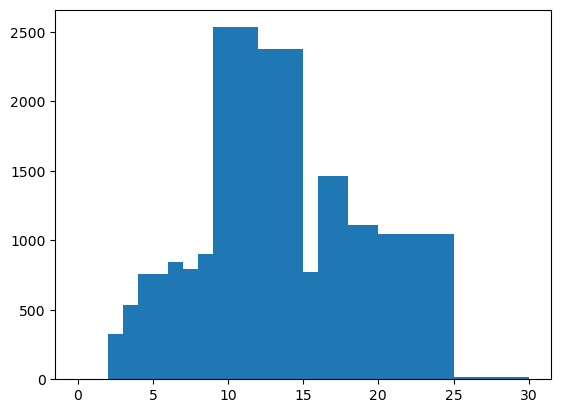

In [5]:
print("maximum length:", max_length(train_text))
plt.hist([len(s.split()) for s in train_text],bins=[0,1,2,3,4,5,6,7,8,9,12,15,16,18,20,25,30])

In [6]:
l=[len(s.split()) for s in train_text]
count=0.0
for i in l:
    if i>22:
        count+=1
print(count,len(l))
print(count/len(l))

128.0 14258
0.008977416187403563


In [7]:
max_seq_length=23

In [11]:
#trainY.count('real'),trainY.count('fake'),testY.count('real'),testY.count('fake')

# Text part

#ALBERT-base


In [2]:
import numpy as np
from transformers import AlbertTokenizer
from tqdm import tqdm  # Import tqdm for progress tracking
import torch

class PaddingInputExample:
    """Fake example so the num input examples is a multiple of the batch size."""
    pass  # No need for methods or properties; just a marker class

class InputExample:
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs an InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence.
            text_b: (Optional) string. The untokenized text of the second sequence.
            label: (Optional) string. The label of the example.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer():
    """Instantiate the ALBERT tokenizer."""
    return AlbertTokenizer.from_pretrained('albert-base-v2')

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""
    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)

    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)

    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""
    input_ids, input_masks, segment_ids, labels = [], [], [], []

    for example in tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)

    return (
        torch.tensor(input_ids),          # Use torch tensors
        torch.tensor(input_masks),        # Use torch tensors
        torch.tensor(segment_ids),        # Use torch tensors
        torch.tensor(labels).reshape(-1, 1)  # Use torch tensors
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    input_examples = []
    for text, label in zip(texts, labels):
        input_examples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return input_examples

# Instantiate the tokenizer
tokenizer = create_tokenizer()

# Convert data to InputExample format
# Assuming train_text and trainY, test_text and testY are already defined
train_examples = convert_text_to_examples(train_text, trainY)
test_examples = convert_text_to_examples(test_text, testY)

# Convert to features
train_input_ids, train_input_masks, train_segment_ids, trainY = convert_examples_to_features(tokenizer, train_examples, max_seq_length=256)
test_input_ids, test_input_masks, test_segment_ids, testY = convert_examples_to_features(tokenizer, test_examples, max_seq_length=256)

# Now you can proceed to use `train_input_ids`, `train_input_masks`, `train_segment_ids`, and `trainY`
# for training your model in PyTorch


Converting examples to features: 100%|██████████| 1923/1923 [00:00<00:00, 2492.39it/s]


In [6]:
# import numpy as np
# from transformers import BertTokenizer
# from tqdm import tqdm  # Import tqdm for progress tracking
# import torch

# class PaddingInputExample:
#     """Fake example so the num input examples is a multiple of the batch size."""
#     pass  # No need for methods or properties; just a marker class

# class InputExample:
#     """A single training/test example for simple sequence classification."""

#     def __init__(self, guid, text_a, text_b=None, label=None):
#         """Constructs an InputExample.

#         Args:
#             guid: Unique id for the example.
#             text_a: string. The untokenized text of the first sequence.
#             text_b: (Optional) string. The untokenized text of the second sequence.
#             label: (Optional) string. The label of the example.
#         """
#         self.guid = guid
#         self.text_a = text_a
#         self.text_b = text_b
#         self.label = label

# def create_tokenizer():
#     """Instantiate the BERT tokenizer."""
#     return BertTokenizer.from_pretrained('bert-base-uncased')

# def convert_single_example(tokenizer, example, max_seq_length=256):
#     """Converts a single `InputExample` into a single `InputFeatures`."""
#     if isinstance(example, PaddingInputExample):
#         input_ids = [0] * max_seq_length
#         input_mask = [0] * max_seq_length
#         segment_ids = [0] * max_seq_length
#         label = 0
#         return input_ids, input_mask, segment_ids, label

#     tokens_a = tokenizer.tokenize(example.text_a)
#     if len(tokens_a) > max_seq_length - 2:
#         tokens_a = tokens_a[0 : (max_seq_length - 2)]

#     tokens = []
#     segment_ids = []
#     tokens.append("[CLS]")
#     segment_ids.append(0)

#     for token in tokens_a:
#         tokens.append(token)
#         segment_ids.append(0)

#     tokens.append("[SEP]")
#     segment_ids.append(0)

#     input_ids = tokenizer.convert_tokens_to_ids(tokens)

#     # The mask has 1 for real tokens and 0 for padding tokens.
#     input_mask = [1] * len(input_ids)

#     # Zero-pad up to the sequence length.
#     while len(input_ids) < max_seq_length:
#         input_ids.append(0)
#         input_mask.append(0)
#         segment_ids.append(0)

#     assert len(input_ids) == max_seq_length
#     assert len(input_mask) == max_seq_length
#     assert len(segment_ids) == max_seq_length

#     return input_ids, input_mask, segment_ids, example.label

# def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
#     """Convert a set of `InputExample`s to a list of `InputFeatures`."""
#     input_ids, input_masks, segment_ids, labels = [], [], [], []

#     for example in tqdm(examples, desc="Converting examples to features"):
#         input_id, input_mask, segment_id, label = convert_single_example(
#             tokenizer, example, max_seq_length
#         )
#         input_ids.append(input_id)
#         input_masks.append(input_mask)
#         segment_ids.append(segment_id)
#         labels.append(label)

#     return (
#         torch.tensor(input_ids),          # Use torch tensors
#         torch.tensor(input_masks),        # Use torch tensors
#         torch.tensor(segment_ids),        # Use torch tensors
#         torch.tensor(labels).reshape(-1, 1)  # Use torch tensors
#     )

# def convert_text_to_examples(texts, labels):
#     """Create InputExamples"""
#     input_examples = []
#     for text, label in zip(texts, labels):
#         input_examples.append(
#             InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
#         )
#     return input_examples

# # Instantiate the tokenizer
# tokenizer = create_tokenizer()

# # Convert data to InputExample format
# # Assuming train_text and trainY, test_text and testY are already defined
# train_examples = convert_text_to_examples(train_text, trainY)
# test_examples = convert_text_to_examples(test_text, testY)

# # Convert to features
# train_input_ids, train_input_masks, train_segment_ids, trainY = convert_examples_to_features(tokenizer, train_examples, max_seq_length=256)
# test_input_ids, test_input_masks, test_segment_ids, testY = convert_examples_to_features(tokenizer, test_examples, max_seq_length=256)

# # Now you can proceed to use `train_input_ids`, `train_input_masks`, `train_segment_ids`, and `trainY`
# # for training your model in PyTorch



Converting examples to features: 100%|██████████| 1923/1923 [00:01<00:00, 1287.85it/s]


# Image Part

In [9]:
length = 224
width = 224
channels = 3

In [ ]:
# def read_and_process_image(list_of_images):
#     X = []
#     for image in tqdm(list_of_images):
# #         print(image)
#         if image is None:
#             print("Error: Image not found or unable to load.", image)

#         else:
#             print("Error: Image found.", image)
#             X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (length,width), interpolation=cv2.INTER_CUBIC))

#     return X

In [ ]:
# images = listdir('images_train/')
# images.extend(listdir('images_test/'))
# jpg = []
# png=[]
# jpeg=[]
# gif = []

# for i in images:
#     name,ext = i.split('.')[0],i.split('.')[-1]
#     eval(ext).append(name)

In [ ]:
# def get_extension_of_file(file_name):
#     if file_name in jpg:
#         return '.jpg'
#     elif file_name in png:
#         return '.png'
#     elif file_name in jpeg:
#         return '.jpeg'
#     else:
#         return '.gif'

In [ ]:
#train_images = [GOOGLE_DRIVE_PATH + '/images_train/'+i+get_extension_of_file(i) for i in train_images]
#test_images = [GOOGLE_DRIVE_PATH + '/images_test/'+i+get_extension_of_file(i) for i in test_images]

In [ ]:
#train_images

In [ ]:
#train_imagesX = read_and_process_image(train_images)
#test_imagesX = read_and_process_image(test_images)

In [ ]:
# from google.colab.patches import cv2_imshow
# image = cv2.imread('drive/My Drive/Deep Learning/Project/mediaeval2015/images_test/eclipse_video_01.gif')
# cv2_imshow(image)

In [ ]:
#np.save(GOOGLE_DRIVE_PATH+'train_imagesX.npy', train_imagesX)

In [ ]:
#np.save(GOOGLE_DRIVE_PATH+'test_imagesX.npy', test_imagesX)

In [3]:
train_imagesX = np.load('train_imagesX.npy')
test_imagesX = np.load('test_imagesX.npy')

In [4]:
train_imagesX = np.rollaxis(train_imagesX, 3, 1)
test_imagesX = np.rollaxis(test_imagesX,3,1)

# Alternatively, using from_numpy which preserves the original data type
train_imagesX = torch.from_numpy(train_imagesX).float()
test_imagesX  = torch.from_numpy(test_imagesX).float()

# The Model

In [5]:
import torch
import torch.nn as nn
from transformers import AlbertModel

class AlbertLayer(nn.Module):
    def __init__(self, albert_path, n_fine_tune_layers=1):
        super(AlbertLayer, self).__init__()
        self.n_fine_tune_layers = n_fine_tune_layers
        self.output_size = 256  # Target output size after dimensionality reduction
        
        # Load pre-trained ALBERT model
        self.albert = AlbertModel.from_pretrained(albert_path)
        
        # Set all layers to non-trainable initially
        for param in self.albert.parameters():
            param.requires_grad = False
            
        # Unfreeze the last `n_fine_tune_layers` layers
        if n_fine_tune_layers > 0:
            for layer in self.albert.encoder.albert_layer_groups[-n_fine_tune_layers:]:
                for param in layer.parameters():
                    param.requires_grad = True
    
        # Linear layer to reduce output size from 768 to 256
        self.fc = nn.Linear(768, self.output_size)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        # Get the pooled output from ALBERT
        outputs = self.albert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        
        # Extract pooled output (representation of [CLS] token)
        pooled_output = outputs.pooler_output
        # Reduce the dimensionality
        reduced_output = self.fc(pooled_output)
        
        return reduced_output

# Example usage:
albert_layer = AlbertLayer(albert_path="albert-base-v2", n_fine_tune_layers=10)
input_ids = torch.tensor([[101, 2009, 2003, 1037, 3071, 102]])  # Example input
attention_mask = torch.tensor([[1, 1, 1, 1, 1, 1]])
output = albert_layer(input_ids=input_ids, attention_mask=attention_mask)
print(output.shape)  # Should print torch.Size([1, 256])


torch.Size([1, 256])


In [10]:
# import torch
# import torch.nn as nn
# from transformers import BertModel

# class BertLayer(nn.Module):
#     def __init__(self, bert_path, n_fine_tune_layers=10):
#         super(BertLayer, self).__init__()
#         self.n_fine_tune_layers = n_fine_tune_layers
#         self.output_size = 256  # BERT-Base output size=768
        
#         # Load pre-trained BERT model
#         self.bert = BertModel.from_pretrained('bert-base-uncased')
        
#         # Set all layers to non-trainable initially
#         for param in self.bert.parameters():
#             param.requires_grad = False
            
#         # Unfreeze the last `n_fine_tune_layers` layers
#         if n_fine_tune_layers > 0:
#             for layer in self.bert.encoder.layer[-n_fine_tune_layers:]:
#                 for param in layer.parameters():
#                     param.requires_grad = True
    
#         # Linear layer to reduce output size from 768 to 256
#         self.fc = nn.Linear(768, self.output_size)

#     def forward(self, input_ids, attention_mask=None, token_type_ids=None):
#         # Get the pooled output from BERT
#         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        
#         # Extract pooled output (representation of [CLS] token)
#         pooled_output = outputs.pooler_output
#         # Reduce the dimensionality
#         reduced_output = self.fc(pooled_output)
        
#         return reduced_output

# #Example usage:
# bert_layer = BertLayer(bert_path="bert-base-uncased", n_fine_tune_layers=10)
# input_ids = torch.tensor([[101, 2009, 2003, 1037, 3071, 102]])  # Example input
# attention_mask = torch.tensor([[1, 1, 1, 1, 1, 1]])
# output = bert_layer(input_ids=input_ids, attention_mask=attention_mask)
# print(output.shape)  # Should print torch.Size([1, 768])


torch.Size([1, 256])


In [14]:
# import torch
# import torch.nn as nn
# from transformers import MobileBertModel

# class BertLayer(nn.Module):
#     def __init__(self, bert_path="google/mobilebert-uncased", n_fine_tune_layers=2):  #n_fine_tune_layers=10
#         super(BertLayer, self).__init__()
#         self.n_fine_tune_layers = n_fine_tune_layers
#         self.output_size = 768  # MobileBERT output size is 768
        
#         # Load pre-trained MobileBERT model
#         self.bert = MobileBertModel.from_pretrained(bert_path)
        
#         # Set all layers to non-trainable initially
#         for param in self.bert.parameters():
#             param.requires_grad = False
            
#         # Unfreeze the last `n_fine_tune_layers` layers
#         if n_fine_tune_layers > 0:
#             for layer in self.bert.encoder.layer[-n_fine_tune_layers:]:
#                 for param in layer.parameters():
#                     param.requires_grad = True

#     def forward(self, input_ids, attention_mask=None, token_type_ids=None):
#         # Get the pooled output from MobileBERT
#         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        
#         # Extract pooled output (representation of [CLS] token)
#         pooled_output = outputs.pooler_output
        
#         return pooled_output

# # Example usage:
# if __name__ == "__main__":
#     bert_layer = BertLayer(n_fine_tune_layers=10)
#     input_ids = torch.tensor([[101, 2009, 2003, 1037, 3071, 102]])  # Example input
#     attention_mask = torch.tensor([[1, 1, 1, 1, 1, 1]])
    
#     output = bert_layer(input_ids=input_ids, attention_mask=attention_mask)
#     print(output.shape)  # Should print torch.Size([1, 768])


torch.Size([1, 512])


Only to run

In [29]:
# from torchvision import models
# # Define the main NewsModel
# class NewsModel(nn.Module):
#     def __init__(self, params):
#         super(NewsModel, self).__init__()
        
#         # Initialize the BertLayer
#         self.bert_layer = BertLayer(bert_path=params["bert_path"], 
#                                     n_fine_tune_layers=params['n_fine_tune_layers'])
        
#         # Text model layers (if additional hidden layers are specified)
#         text_hidden_layers = []
#         input_size = self.bert_layer.output_size
#         for _ in range(params['text_no_hidden_layer']):
#             text_hidden_layers.append(nn.Linear(input_size, params['text_hidden_neurons']))
#             text_hidden_layers.append(nn.ReLU())
#             text_hidden_layers.append(nn.Dropout(params['dropout']))
#             input_size = params['text_hidden_neurons']
#         self.text_hidden_layers = nn.Sequential(*text_hidden_layers)
        
#         self.text_repr = nn.Linear(input_size, params['repr_size'])
        
#         # Image model with VGG-19 feature extractor
#         self.vgg_base = models.vgg19(pretrained=True)
#         self.vgg_base.classifier = nn.Identity()  # Remove classifier for feature extraction
#         for param in self.vgg_base.parameters():
#             param.requires_grad = False  # Freeze VGG base layers
        
#         # Additional hidden layers for image model (if specified)
#         vis_hidden_layers = []
#         input_size = 512 * 7 * 7  # Flattened output from VGG19's feature extractor
#         for _ in range(params['vis_no_hidden_layer']):
#             vis_hidden_layers.append(nn.Linear(input_size, params['vis_hidden_neurons']))
#             vis_hidden_layers.append(nn.ReLU())
#             vis_hidden_layers.append(nn.Dropout(params['dropout']))
#             input_size = params['vis_hidden_neurons']
#         self.vis_hidden_layers = nn.Sequential(*vis_hidden_layers)

#         self.visual_repr = nn.Linear(input_size, params['repr_size'])
        
#         # Final combined classifier
#         combined_size = 2 * params['repr_size']
#         final_hidden_layers = []
#         for _ in range(params['final_no_hidden_layer']):
#             final_hidden_layers.append(nn.Linear(combined_size, params['final_hidden_neurons']))
#             final_hidden_layers.append(nn.ReLU())
#             final_hidden_layers.append(nn.Dropout(params['dropout']))
#             combined_size = params['final_hidden_neurons']
#         self.final_hidden_layers = nn.Sequential(*final_hidden_layers)

#         self.classifier = nn.Linear(combined_size, 1)  # Binary classification
    
#     def forward(self, input_ids, attention_mask, token_type_ids, image):
#         # BERT forward pass
#         text_output = self.bert_layer(input_ids, attention_mask, token_type_ids)
#         text_output = self.text_hidden_layers(text_output)
#         text_repr = self.text_repr(text_output)
        
#         # VGG-19 forward pass
#         image_features = self.vgg_base(image)
#         image_flatten = image_features.view(image_features.size(0), -1)  # Flatten for fully connected layers
#         image_output = self.vis_hidden_layers(image_flatten)
#         visual_repr = self.visual_repr(image_output)
        
#         # Concatenate text and visual representations
#         combined_repr = torch.cat((text_repr, visual_repr), dim=1)
#         combined_output = self.final_hidden_layers(combined_repr)
        
#         # Final classifier layer
#         prediction = torch.sigmoid(self.classifier(combined_output))
#         print(f"Prediction shape: {prediction.shape}")  # Debugging line
#         return prediction

In [9]:
from torchvision import models
# Define the main NewsModel
class NewsModel(nn.Module):
    def __init__(self, params):
        super(NewsModel, self).__init__()
        
        # Initialize the BertLayer
        self.bert_layer = AlbertLayer(albert_path="albert-base-v2", 
                                    n_fine_tune_layers=params['n_fine_tune_layers'])
        
        # Text model layers (if additional hidden layers are specified)
        text_hidden_layers = []
        input_size = self.bert_layer.output_size
        for _ in range(params['text_no_hidden_layer']):
            text_hidden_layers.append(nn.Linear(input_size, params['text_hidden_neurons']))
            text_hidden_layers.append(nn.ReLU())
            text_hidden_layers.append(nn.Dropout(params['dropout']))
            input_size = params['text_hidden_neurons']
        self.text_hidden_layers = nn.Sequential(*text_hidden_layers)
        
        self.text_repr = nn.Linear(input_size, params['repr_size'])
        
        # Image model with MobileNet feature extractor
        self.mobilenet_base = models.mobilenet_v2(pretrained=True)  # Use MobileNetV2
        self.mobilenet_base.classifier = nn.Identity()  # Remove classifier for feature extraction
        for param in self.mobilenet_base.parameters():
            param.requires_grad = False  # Freeze MobileNet base layers
        
        # Additional hidden layers for image model (if specified)
        vis_hidden_layers = []
        input_size = 1280  # Flattened output from MobileNetV2
        for _ in range(params['vis_no_hidden_layer']):
            vis_hidden_layers.append(nn.Linear(input_size, params['vis_hidden_neurons']))
            vis_hidden_layers.append(nn.ReLU())
            vis_hidden_layers.append(nn.Dropout(params['dropout']))
            input_size = params['vis_hidden_neurons']
        self.vis_hidden_layers = nn.Sequential(*vis_hidden_layers)

        self.visual_repr = nn.Linear(input_size, params['repr_size'])
        
        # Final combined classifier
        combined_size = 2 * params['repr_size']
        final_hidden_layers = []
        for _ in range(params['final_no_hidden_layer']):
            final_hidden_layers.append(nn.Linear(combined_size, params['final_hidden_neurons']))
            final_hidden_layers.append(nn.ReLU())
            final_hidden_layers.append(nn.Dropout(params['dropout']))
            combined_size = params['final_hidden_neurons']
        self.final_hidden_layers = nn.Sequential(*final_hidden_layers)

        self.classifier = nn.Linear(combined_size, 1)  # Binary classification
    
    def forward(self, input_ids, attention_mask, token_type_ids, image):
        # BERT forward pass
        text_output = self.bert_layer(input_ids, attention_mask, token_type_ids)
        text_output = self.text_hidden_layers(text_output)
        text_repr = self.text_repr(text_output)
        
        # VGG-19 forward pass
        image_features = self.mobilenet_base(image)
        #image_flatten = image_features.view(image_features.size(0), -1)  # Flatten for fully connected layers
        #image_output = self.vis_hidden_layers(image_flatten)
        image_output = self.vis_hidden_layers(image_features )
        visual_repr = self.visual_repr(image_output)
        
        # Concatenate text and visual representations
        combined_repr = torch.cat((text_repr, visual_repr), dim=1)
        combined_output = self.final_hidden_layers(combined_repr)
        
        # Final classifier layer
        prediction = torch.sigmoid(self.classifier(combined_output))
        
        return prediction

In [10]:
params = {
    'albert_path':"albert-base-v2",
    'n_fine_tune_layers':1,
    'bert_trainable' :False,
    'text_no_hidden_layer':1,
    'text_hidden_neurons':64,   #'text_hidden_neurons':768,
    'dropout':0.4,
    'repr_size':32,
    'vis_no_hidden_layer':1,
    'vis_hidden_neurons':64,   #'vis_hidden_neurons':2742,
    'final_no_hidden_layer':1,
    'final_hidden_neurons':35,
    'optimizer':['adam'],
    'batch_size':[1],
    'epochs':[10]
}

In [11]:
import torch

# Check if CUDA is available
is_cuda_available = torch.cuda.is_available()
print(f"Is CUDA available? {is_cuda_available}")

# If CUDA is available, get the current device
if is_cuda_available:
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"Current GPU device: {device_name}")
else:
    print("Using CPU")


Is CUDA available? True
Current GPU device: NVIDIA GeForce RTX 3060 Laptop GPU


In [16]:
import numpy as np
import torch.optim as optim
import torch.nn as nn

class LRFinder:
    def __init__(self, model, criterion=nn.BCELoss(), optimizer=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.history = {
            "lr": [],
            "loss": []
        }

    def run(self, input_ids, attention_mask, token_type_ids, images, labels, 
            lr):
        # Put model in training mode
        self.model.train()

        # Setup optimizer if not already provided
        if self.optimizer is None:
            self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        # Move inputs to device
        device = next(self.model.parameters()).device
        input_ids, attention_mask, token_type_ids, images, labels = (
            input_ids.to(device),
            attention_mask.to(device),
            token_type_ids.to(device),
            images.to(device),
            labels.float().to(device)
        )

        # Forward pass
        outputs = self.model(input_ids, attention_mask, token_type_ids, images)
        outputs = outputs.unsqueeze(1)
        loss = self.criterion(outputs.squeeze(), labels.squeeze())

        # Record the loss and learning rate
        self.history['lr'].append(lr)
        self.history['loss'].append(loss.item())

        # Perform backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Print results
        print(f"Learning Rate: {lr:.2e}, Loss: {loss.item():.4f}")

# Example usage
# Assuming you have prepared your training data: train_input_ids, train_input_masks, train_segment_ids, train_imagesX, trainY

# Create the model
model_adam = NewsModel(params).to(current_device)

# Initialize the learning rate finder
lr_finder = LRFinder(model_adam)

# Run the model with a fixed learning rate (you can set the desired learning rate here)
fixed_lr = 0.001  # Set the learning rate you want to test
lr_finder.run(train_input_ids, train_input_masks, train_segment_ids, train_imagesX, trainY, 
               lr=fixed_lr)

# After running the model, you can visualize the results if needed


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.48 GiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 17.72 GiB is allocated by PyTorch, and 107.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [1]:
# import numpy as np
# import torch.optim as optim

# class LRFinder:
#     def __init__(self, model, criterion=nn.BCELoss(), optimizer=None):
#         self.model = model
#         self.criterion = criterion
#         self.optimizer = optimizer
#         self.history = {
#             "lr": [],
#             "loss": []
#         }

#     def find(self, input_ids, attention_mask, token_type_ids, images, labels, 
#              start_lr, end_lr, num_iter, beta=0.98):
#         # Put model in training mode
#         self.model.train()

#         # Setup optimizer if not already provided
#         if self.optimizer is None:
#             self.optimizer = optim.Adam(self.model.parameters(), lr=start_lr)

#         # Clear the gradients
#         self.optimizer.zero_grad()

#         # Calculate the total number of iterations
#         num_samples = len(labels)
#         iteration = 0
        
#         # Move inputs to device
#         device = next(self.model.parameters()).device
#         input_ids, attention_mask, token_type_ids, images, labels = (
#             input_ids.to(device),
#             attention_mask.to(device),
#             token_type_ids.to(device),
#             images.to(device),
#             labels.float().to(device)
#         )

#         # Learning rate schedule
#         lr_schedule = np.logspace(np.log10(start_lr), np.log10(end_lr), num_iter)

#         for lr in lr_schedule:
#             self.optimizer.param_groups[0]['lr'] = lr
#             outputs = self.model(input_ids, attention_mask, token_type_ids, images)
#             loss = self.criterion(outputs.squeeze(), labels)

#             # Record the loss and learning rate
#             self.history['lr'].append(lr)
#             self.history['loss'].append(loss.item())

#             # Perform backpropagation
#             self.optimizer.zero_grad()
#             loss.backward()
#             self.optimizer.step()

#             # Optionally print progress
#             if iteration % (num_iter // 10) == 0:
#                 print(f"Iteration {iteration}/{num_iter}: lr={lr:.2e}, loss={loss.item():.4f}")

#             iteration += 1
        
#         print("Finished LR Finder.")

# # Example usage
# # Assuming you have prepared your training data: train_input_ids, train_input_masks, train_segment_ids, train_imagesX, trainY

# # Create the model
# model_adam = NewsModel(params).to(current_device)

# # Initialize the learning rate finder
# lr_finder = LRFinder(model_adam)

# # Find the optimal learning rate
# lr_finder.find(train_input_ids, train_input_masks, train_segment_ids, train_imagesX, trainY,
#                 start_lr=0.000001, end_lr=0.01, num_iter=128)

# # After running the LR Finder, you can plot the results to visualize the optimal learning rate
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.plot(lr_finder.history['lr'], lr_finder.history['loss'])
# plt.xscale('log')
# plt.xlabel('Learning Rate')
# plt.ylabel('Loss')
# plt.title('Learning Rate Finder')
# plt.grid()
# plt.show()


In [15]:
import numpy as np
import torch.optim as optim
import torch.nn as nn

class LRFinder:
    def __init__(self, model, criterion=nn.BCELoss(), optimizer=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.history = {
            "lr": [],
            "loss": []
        }

    def run(self, input_ids, attention_mask, token_type_ids, images, labels, lr):
        # Put model in training mode
        self.model.train()

        # Setup optimizer if not already provided
        if self.optimizer is None:
            self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        # Move inputs to device
        device = next(self.model.parameters()).device
        input_ids, attention_mask, token_type_ids, images, labels = (
            input_ids.to(device),
            attention_mask.to(device),
            token_type_ids.to(device),
            images.to(device),
            labels.float().to(device)  # Ensure labels are float for BCELoss
        )

        # Forward pass
        outputs = self.model(input_ids, attention_mask, token_type_ids, images)
        outputs = outputs.unsqueeze(1)
        print(f"labels shape: {labels.shape}")  # Debugging line
        loss = self.criterion(outputs.squeeze(), labels.squeeze())

        # Record the loss and learning rate
        self.history['lr'].append(lr)
        self.history['loss'].append(loss.item())

        # Perform backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Print results
        print(f"Learning Rate: {lr:.2e}, Loss: {loss.item():.4f}")


# Example usage
# Assuming you have prepared your training data: train_input_ids, train_input_masks, train_segment_ids, train_imagesX, trainY

# Create the model
model_adam = NewsModel(params).to(current_device)

# Initialize the learning rate finder
lr_finder = LRFinder(model_adam)

# Run the model with a fixed learning rate (you can set the desired learning rate here)
fixed_lr = 0.001  # Set the learning rate you want to test
try:
    lr_finder.run(train_input_ids[0:1], train_input_masks[0:1], train_segment_ids[0:1], train_imagesX[0:1], trainY[0:1], 
                   lr=fixed_lr)
except Exception as e:
    print(f"An error occurred: {e}")


c:\ProgramData\anaconda3\envs\pytorch\lib\site-packages\transformers\models\albert\modeling_albert.py:404: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attention_output = torch.nn.functional.scaled_dot_product_attention(


labels shape: torch.Size([1, 1])
Learning Rate: 1.00e-03, Loss: 0.6586


In [44]:
import torch
import torch.nn as nn
from torchvision import models

class NewsModel(nn.Module):
    def __init__(self, params):
        super(NewsModel, self).__init__()
        
        # Initialize the BertLayer (assuming it's defined)
        self.bert_layer = BertLayer(bert_path=params["bert_path"], 
                                    n_fine_tune_layers=params['n_fine_tune_layers'])
        
        # Text model layers
        text_hidden_layers = []
        input_size = self.bert_layer.output_size
        for _ in range(params['text_no_hidden_layer']):
            text_hidden_layers.append(nn.Linear(input_size, params['text_hidden_neurons']))
            text_hidden_layers.append(nn.ReLU())
            text_hidden_layers.append(nn.Dropout(params['dropout']))
            input_size = params['text_hidden_neurons']
        self.text_hidden_layers = nn.Sequential(*text_hidden_layers)
        
        self.text_repr = nn.Linear(input_size, params['repr_size'])
        
        # VGG-19 feature extractor
        self.vgg_base = models.vgg19(pretrained=True)
        self.vgg_base.classifier = nn.Identity()  # Remove classifier for feature extraction
        for param in self.vgg_base.parameters():
            param.requires_grad = False  # Freeze VGG base layers
        
        # Image model layers
        vis_hidden_layers = []
        input_size = 512 * 7 * 7  # Flattened output from VGG19's feature extractor
        for _ in range(params['vis_no_hidden_layer']):
            vis_hidden_layers.append(nn.Linear(input_size, params['vis_hidden_neurons']))
            vis_hidden_layers.append(nn.ReLU())
            vis_hidden_layers.append(nn.Dropout(params['dropout']))
            input_size = params['vis_hidden_neurons']
        self.vis_hidden_layers = nn.Sequential(*vis_hidden_layers)

        self.visual_repr = nn.Linear(input_size, params['repr_size'])
        
        # Final classifier
        combined_size = 2 * params['repr_size']
        final_hidden_layers = []
        for _ in range(params['final_no_hidden_layer']):
            final_hidden_layers.append(nn.Linear(combined_size, params['final_hidden_neurons']))
            final_hidden_layers.append(nn.ReLU())
            final_hidden_layers.append(nn.Dropout(params['dropout']))
            combined_size = params['final_hidden_neurons']
        self.final_hidden_layers = nn.Sequential(*final_hidden_layers)

        self.classifier = nn.Linear(combined_size, 1)  # Binary classification
    
    def forward(self, input_ids, attention_mask, token_type_ids, image):
        # BERT forward pass
        text_output = self.bert_layer(input_ids, attention_mask, token_type_ids)
        text_output = self.text_hidden_layers(text_output)
        text_repr = self.text_repr(text_output)
        
        # VGG-19 forward pass
        image_features = self.vgg_base(image)
        image_flatten = image_features.view(image_features.size(0), -1)  # Flatten for fully connected layers
        image_output = self.vis_hidden_layers(image_flatten)
        visual_repr = self.visual_repr(image_output)
        
        # Concatenate text and visual representations
        combined_repr = torch.cat((text_repr, visual_repr), dim=1)
        combined_output = self.final_hidden_layers(combined_repr)
        
        # Final classifier layer
        prediction = torch.sigmoid(self.classifier(combined_output))
        return prediction

    def total_params(self):
        return sum(p.numel() for p in self.parameters())

# Example parameters (modify as needed)
params = {
    'bert_path':'bert-base-uncased',
    'n_fine_tune_layers':2,
    'bert_trainable' :False,
    'text_no_hidden_layer':1,
    'text_hidden_neurons':128,   #'text_hidden_neurons':768,
    'dropout':0.4,
    'repr_size':32,
    'vis_no_hidden_layer':1,
    'vis_hidden_neurons':128,   #'vis_hidden_neurons':2742,
    'final_no_hidden_layer':1,
    'final_hidden_neurons':35,
    'optimizer':['adam'],
    'batch_size':[8],
    'epochs':[10]
}
model = NewsModel(params)
print(f'Total number of parameters in the model: {model.total_params()}')


Total number of parameters in the model: 132958343


In [28]:
class NewsModel(nn.Module):
    def __init__(self, params):
        super(NewsModel, self).__init__()
        
        # Initialize the BertLayer
        self.bert_layer = AlbertLayer(albert_path="albert-base-v2", 
                                    n_fine_tune_layers=params['n_fine_tune_layers'])
        
        # Text model layers (if additional hidden layers are specified)
        text_hidden_layers = []
        input_size = self.bert_layer.output_size
        for _ in range(params['text_no_hidden_layer']):
            text_hidden_layers.append(nn.Linear(input_size, params['text_hidden_neurons']))
            text_hidden_layers.append(nn.ReLU())
            text_hidden_layers.append(nn.Dropout(params['dropout']))
            input_size = params['text_hidden_neurons']
        self.text_hidden_layers = nn.Sequential(*text_hidden_layers)
        
        self.text_repr = nn.Linear(input_size, params['repr_size'])
        
        # Image model with MobileNet feature extractor
        self.mobilenet_base = models.mobilenet_v2(pretrained=True)  # Use MobileNetV2
        self.mobilenet_base.classifier = nn.Identity()  # Remove classifier for feature extraction
        for param in self.mobilenet_base.parameters():
            param.requires_grad = False  # Freeze MobileNet base layers
        
        # Additional hidden layers for image model (if specified)
        vis_hidden_layers = []
        input_size = 1280  # Flattened output from MobileNetV2
        for _ in range(params['vis_no_hidden_layer']):
            vis_hidden_layers.append(nn.Linear(input_size, params['vis_hidden_neurons']))
            vis_hidden_layers.append(nn.ReLU())
            vis_hidden_layers.append(nn.Dropout(params['dropout']))
            input_size = params['vis_hidden_neurons']
        self.vis_hidden_layers = nn.Sequential(*vis_hidden_layers)

        self.visual_repr = nn.Linear(input_size, params['repr_size'])
        
        # Final combined classifier
        combined_size = 2 * params['repr_size']
        final_hidden_layers = []
        for _ in range(params['final_no_hidden_layer']):
            final_hidden_layers.append(nn.Linear(combined_size, params['final_hidden_neurons']))
            final_hidden_layers.append(nn.ReLU())
            final_hidden_layers.append(nn.Dropout(params['dropout']))
            combined_size = params['final_hidden_neurons']
        self.final_hidden_layers = nn.Sequential(*final_hidden_layers)

        self.classifier = nn.Linear(combined_size, 1)  # Binary classification
    
    def forward(self, input_ids, attention_mask, token_type_ids, image):
        # BERT forward pass
        text_output = self.bert_layer(input_ids, attention_mask, token_type_ids)
        text_output = self.text_hidden_layers(text_output)
        text_repr = self.text_repr(text_output)
        
        # VGG-19 forward pass
        image_features = self.mobilenet_base(image)
        #image_flatten = image_features.view(image_features.size(0), -1)  # Flatten for fully connected layers
        #image_output = self.vis_hidden_layers(image_flatten)
        image_output = self.vis_hidden_layers(image_features )
        visual_repr = self.visual_repr(image_output)
        
        # Concatenate text and visual representations
        combined_repr = torch.cat((text_repr, visual_repr), dim=1)
        combined_output = self.final_hidden_layers(combined_repr)
        
        # Final classifier layer
        prediction = torch.sigmoid(self.classifier(combined_output))
        
        return prediction
    
    def total_params(self):
        return sum(p.numel() for p in self.parameters())

# Example parameters (modify as needed)
params = {
    'bert_path':'bert-base-uncased',
    'n_fine_tune_layers':2,
    'bert_trainable' :False,
    'text_no_hidden_layer':1,
    'text_hidden_neurons':128,   #'text_hidden_neurons':768,
    'dropout':0.4,
    'repr_size':32,
    'vis_no_hidden_layer':1,
    'vis_hidden_neurons':128,   #'vis_hidden_neurons':2742,
    'final_no_hidden_layer':1,
    'final_hidden_neurons':35,
    'optimizer':['adam'],
    'batch_size':[8],
    'epochs':[10]
}
model = NewsModel(params)
print(f'Total number of parameters in the model: {model.total_params()}')

Total number of parameters in the model: 14311751


In [14]:
class NewsModel(nn.Module):
    def __init__(self, params):
        super(NewsModel, self).__init__()
        
        # Initialize the BertLayer
        self.bert_layer = AlbertLayer(albert_path="albert-base-v2", 
                                    n_fine_tune_layers=params['n_fine_tune_layers'])
        
        # Text model layers (if additional hidden layers are specified)
        text_hidden_layers = []
        input_size = self.bert_layer.output_size
        for _ in range(params['text_no_hidden_layer']):
            text_hidden_layers.append(nn.Linear(input_size, params['text_hidden_neurons']))
            text_hidden_layers.append(nn.ReLU())
            text_hidden_layers.append(nn.Dropout(params['dropout']))
            input_size = params['text_hidden_neurons']
        self.text_hidden_layers = nn.Sequential(*text_hidden_layers)
        
        self.text_repr = nn.Linear(input_size, params['repr_size'])
        
        # Image model with MobileNet feature extractor
        self.mobilenet_base = models.mobilenet_v2(pretrained=True)  # Use MobileNetV2
        self.mobilenet_base.classifier = nn.Identity()  # Remove classifier for feature extraction
        for param in self.mobilenet_base.parameters():
            param.requires_grad = False  # Freeze MobileNet base layers
        
        # Additional hidden layers for image model (if specified)
        vis_hidden_layers = []
        input_size = 1280  # Flattened output from MobileNetV2
        for _ in range(params['vis_no_hidden_layer']):
            vis_hidden_layers.append(nn.Linear(input_size, params['vis_hidden_neurons']))
            vis_hidden_layers.append(nn.ReLU())
            vis_hidden_layers.append(nn.Dropout(params['dropout']))
            input_size = params['vis_hidden_neurons']
        self.vis_hidden_layers = nn.Sequential(*vis_hidden_layers)

        self.visual_repr = nn.Linear(input_size, params['repr_size'])
        
        # Final combined classifier
        combined_size = 2 * params['repr_size']
        final_hidden_layers = []
        for _ in range(params['final_no_hidden_layer']):
            final_hidden_layers.append(nn.Linear(combined_size, params['final_hidden_neurons']))
            final_hidden_layers.append(nn.ReLU())
            final_hidden_layers.append(nn.Dropout(params['dropout']))
            combined_size = params['final_hidden_neurons']
        self.final_hidden_layers = nn.Sequential(*final_hidden_layers)

        self.classifier = nn.Linear(combined_size, 1)  # Binary classification
    
    def forward(self, input_ids, attention_mask, token_type_ids, image):
        # BERT forward pass
        text_output = self.bert_layer(input_ids, attention_mask, token_type_ids)
        text_output = self.text_hidden_layers(text_output)
        text_repr = self.text_repr(text_output)
        
        # VGG-19 forward pass
        image_features = self.mobilenet_base(image)
        #image_flatten = image_features.view(image_features.size(0), -1)  # Flatten for fully connected layers
        #image_output = self.vis_hidden_layers(image_flatten)
        image_output = self.vis_hidden_layers(image_features )
        visual_repr = self.visual_repr(image_output)
        
        # Concatenate text and visual representations
        combined_repr = torch.cat((text_repr, visual_repr), dim=1)
        combined_output = self.final_hidden_layers(combined_repr)
        
        # Final classifier layer
        prediction = torch.sigmoid(self.classifier(combined_output))
        
        return prediction
    
    def total_params(self):
        return sum(p.numel() for p in self.parameters())

# Example parameters (modify as needed)
params = {
    'bert_path':'bert-base-uncased',
    'n_fine_tune_layers':1,
    'bert_trainable' :False,
    'text_no_hidden_layer':1,
    'text_hidden_neurons':64,   #'text_hidden_neurons':768,
    'dropout':0.4,
    'repr_size':32,
    'vis_no_hidden_layer':1,
    'vis_hidden_neurons':64,   #'vis_hidden_neurons':2742,
    'final_no_hidden_layer':1,
    'final_hidden_neurons':35,
    'optimizer':['adam'],
    'batch_size':[1],
    'epochs':[10]
}
model = NewsModel(params)
print(f'Total number of parameters in the model: {model.total_params()}')

Total number of parameters in the model: 14209223
